In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

import torch
import torch.nn as nn
import torchvision.transforms as T
import open_clip
from PIL import Image

import requests
from io import BytesIO
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# Загрузка CLIP ViT-B/32
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model = model.to(device).eval()
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [3]:
# Путь к тестовым изображениям
test_images_dir = "./test_images"
image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith('.png')])
print(f"Найдено изображений: {len(image_files)}")
print(f"Файлы: {image_files}")

Найдено изображений: 6
Файлы: ['building.png', 'car.png', 'dawn.png', 'dog.png', 'human.png', 'tree.png']


In [4]:
# Подготовка изображений и извлечение активаций со всех слоёв
def load_and_preprocess_image(path):
    """Загрузка и препроцессинг изображения под требования CLIP"""
    img = Image.open(path).convert("RGB")
    return preprocess_val(img).unsqueeze(0).to(device)

In [5]:
# Хранилище активаций: {номер_слоя: [активации для каждого изображения]}
layer_activations = {i: [] for i in range(12)}  # ViT-B/32 имеет 12 слоёв

In [ ]:
# Регистрация хуков для каждого слоя
activation_hooks = {}

def get_activation_hook(layer_idx):
    def hook(module, input, output):
        # Обработка возможного кортежа выхода
        x = output[0] if isinstance(output, tuple) else output

        # Определение формата по размеру последовательности (50 = 49 патчей + 1 CLS)
        if x.ndim == 3:
            if x.shape[1] == 50:  # Формат [batch, seq_len, dim]
                cls_token = x[:, 0, :]  # Извлекаем первый токен (CLS) для всех батчей
            elif x.shape[0] == 50:  # Формат [seq_len, batch, dim]
                cls_token = x[0, :, :]
            else:
                raise ValueError(f"Неизвестная конфигурация последовательности: {x.shape}")
        elif x.ndim == 2:
            # Для батча размером 1 иногда возвращается [seq_len, dim]
            cls_token = x[0, :].unsqueeze(0)
        else:
            raise ValueError(f"Неожиданная размерность: {x.shape}")

        layer_activations[layer_idx].append(cls_token.detach().cpu())
    return hook


In [7]:
# Удаление старых хуков (на случай, если ячейка запускается повторно)
for block in model.visual.transformer.resblocks:
    block._forward_hooks.clear()

In [8]:
# Установка хуков на каждый блок внимания
for idx, block in enumerate(model.visual.transformer.resblocks):
    handle = block.register_forward_hook(get_activation_hook(idx))
    activation_hooks[f"layer_{idx}"] = handle

In [9]:
# Прогон изображений через модель
images_tensors = []
for img_file in image_files:
    img_path = os.path.join(test_images_dir, img_file)
    img_tensor = load_and_preprocess_image(img_path)
    images_tensors.append(img_tensor)
    with torch.no_grad():
        _ = model.encode_image(img_tensor)  # активирует хуки

c:\MyPythonProjects\default_venv\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


In [10]:
# Удаление хуков после прогона
for handle in activation_hooks.values():
    handle.remove()

In [11]:
print(f"Извлечены активации для {len(image_files)} изображений на {len(layer_activations)} слоях")
for layer_idx in range(12):
    if layer_activations[layer_idx]:
        print(f"Слой {layer_idx}: {len(layer_activations[layer_idx])} батчей, размерность {layer_activations[layer_idx][0].shape}")

Извлечены активации для 6 изображений на 12 слоях
Слой 0: 6 батчей, размерность torch.Size([1, 768])
Слой 1: 6 батчей, размерность torch.Size([1, 768])
Слой 2: 6 батчей, размерность torch.Size([1, 768])
Слой 3: 6 батчей, размерность torch.Size([1, 768])
Слой 4: 6 батчей, размерность torch.Size([1, 768])
Слой 5: 6 батчей, размерность torch.Size([1, 768])
Слой 6: 6 батчей, размерность torch.Size([1, 768])
Слой 7: 6 батчей, размерность torch.Size([1, 768])
Слой 8: 6 батчей, размерность torch.Size([1, 768])
Слой 9: 6 батчей, размерность torch.Size([1, 768])
Слой 10: 6 батчей, размерность torch.Size([1, 768])
Слой 11: 6 батчей, размерность torch.Size([1, 768])


In [ ]:
# Анализ статистик активаций по слоям
# Сбор статистик для каждого слоя
stats_per_layer = []
for layer_idx in range(12):
    activations = torch.cat(layer_activations[layer_idx], dim=0)  # [num_images, dim]
    mean_abs = activations.abs().mean().item()
    std = activations.std().item()
    norm_l2 = activations.norm(dim=1).mean().item()

    # L0 разреженность при разных порогах
    l0_1e3 = (activations.abs() > 1e-3).float().mean(dim=1).mean().item()
    l0_1e4 = (activations.abs() > 1e-4).float().mean(dim=1).mean().item()

    stats_per_layer.append({
        "layer": layer_idx,
        "mean_abs": mean_abs,
        "std": std,
        "l2_norm": norm_l2,
        "l0_1e-3": l0_1e3,
        "l0_1e-4": l0_1e4
    })

df_stats = pd.DataFrame(stats_per_layer)
print(df_stats.round(4).to_string(index=False))

 layer  mean_abs    std  l2_norm  l0_1e-3  l0_1e-4
     0    0.0976 0.3559  10.0310   0.9944   0.9998
     1    0.0702 0.2935   8.2318   0.9876   0.9989
     2    0.0519 0.2675   7.4686   0.9844   0.9978
     3    0.0563 0.2809   7.8161   0.9868   0.9985
     4    0.0551 0.2444   6.7936   0.9868   0.9980
     5    0.0617 0.2407   6.6804   0.9876   0.9991
     6    0.0655 0.2608   7.2348   0.9861   0.9993
     7    0.0848 0.3236   8.9702   0.9900   0.9993
     8    0.1387 0.4723  13.0800   0.9950   0.9991
     9    0.1741 0.4510  12.4882   0.9954   0.9996
    10    0.2856 0.7024  19.4657   0.9972   0.9996
    11    0.2426 0.3111   8.5928   0.9970   1.0000


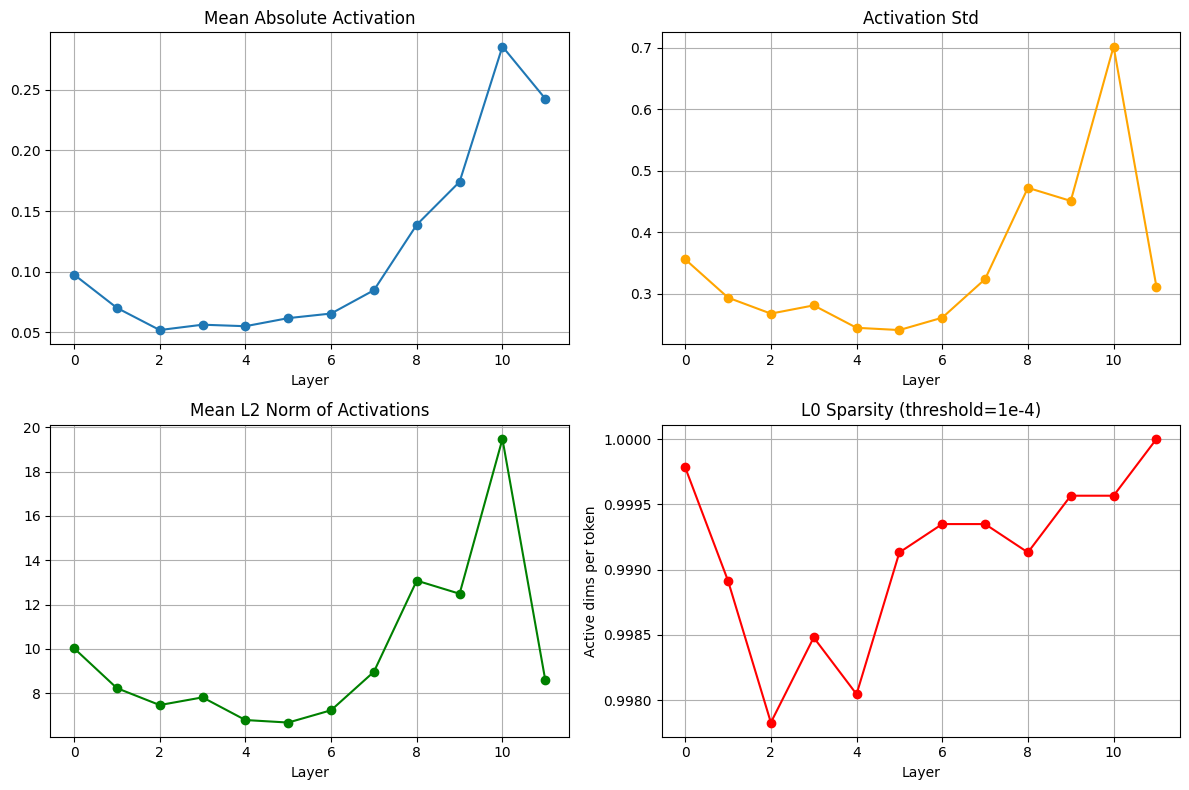

In [13]:
# Визуализация динамики статистик по слоям
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Среднее абсолютное значение
axes[0, 0].plot(df_stats["layer"], df_stats["mean_abs"], marker='o')
axes[0, 0].set_title("Mean Absolute Activation")
axes[0, 0].set_xlabel("Layer")
axes[0, 0].grid(True)

# Стандартное отклонение
axes[0, 1].plot(df_stats["layer"], df_stats["std"], marker='o', color='orange')
axes[0, 1].set_title("Activation Std")
axes[0, 1].set_xlabel("Layer")
axes[0, 1].grid(True)

# L2 норма
axes[1, 0].plot(df_stats["layer"], df_stats["l2_norm"], marker='o', color='green')
axes[1, 0].set_title("Mean L2 Norm of Activations")
axes[1, 0].set_xlabel("Layer")
axes[1, 0].grid(True)

# L0 разреженность (порог 1e-4)
axes[1, 1].plot(df_stats["layer"], df_stats["l0_1e-4"], marker='o', color='red')
axes[1, 1].set_title("L0 Sparsity (threshold=1e-4)")
axes[1, 1].set_xlabel("Layer")
axes[1, 1].set_ylabel("Active dims per token")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

Статистики активаций по слоям:

1. mean_abs
    - Минимум на слоях 2-5 (0.05), пик на слое 10 (0.285), спад на 11 (0.24)
    - Ранние слои кодируют низкоуровневые признаки (текстуры) с малой амплитудой. К слою 10 накапливается семантическая информация -> рост активаций
    - Слой 11: финальная обработка/нормализация -> снижение амплитуды
2. std
    - Минимум на слое 5 (0.24), пик на слое 10 (0.7), резкий спад на 11 (0.31)
    - Высокая дисперсия на слое 10 = максимальная информативность: разные изображения вызывают сильно различающиеся активации
    - Слой 11 "сглаживает" различия (возможно, из-за финальной проекции в 512D пространство)
3. L2 norm
    - Минимум на слое 5 (6.68), пик на слое 10 (19.47), спад на 11 (8.59)
    - Подтверждает: слой 10 содержит наиболее "энергичные" представления - оптимальная точка для декомпозиции на фичи
4. L0 (порог 1e-4)
    - ~1.0 для всех слоёв, неинформативно
    - Для анализа разреженности нужны пороги 0.1–0.5


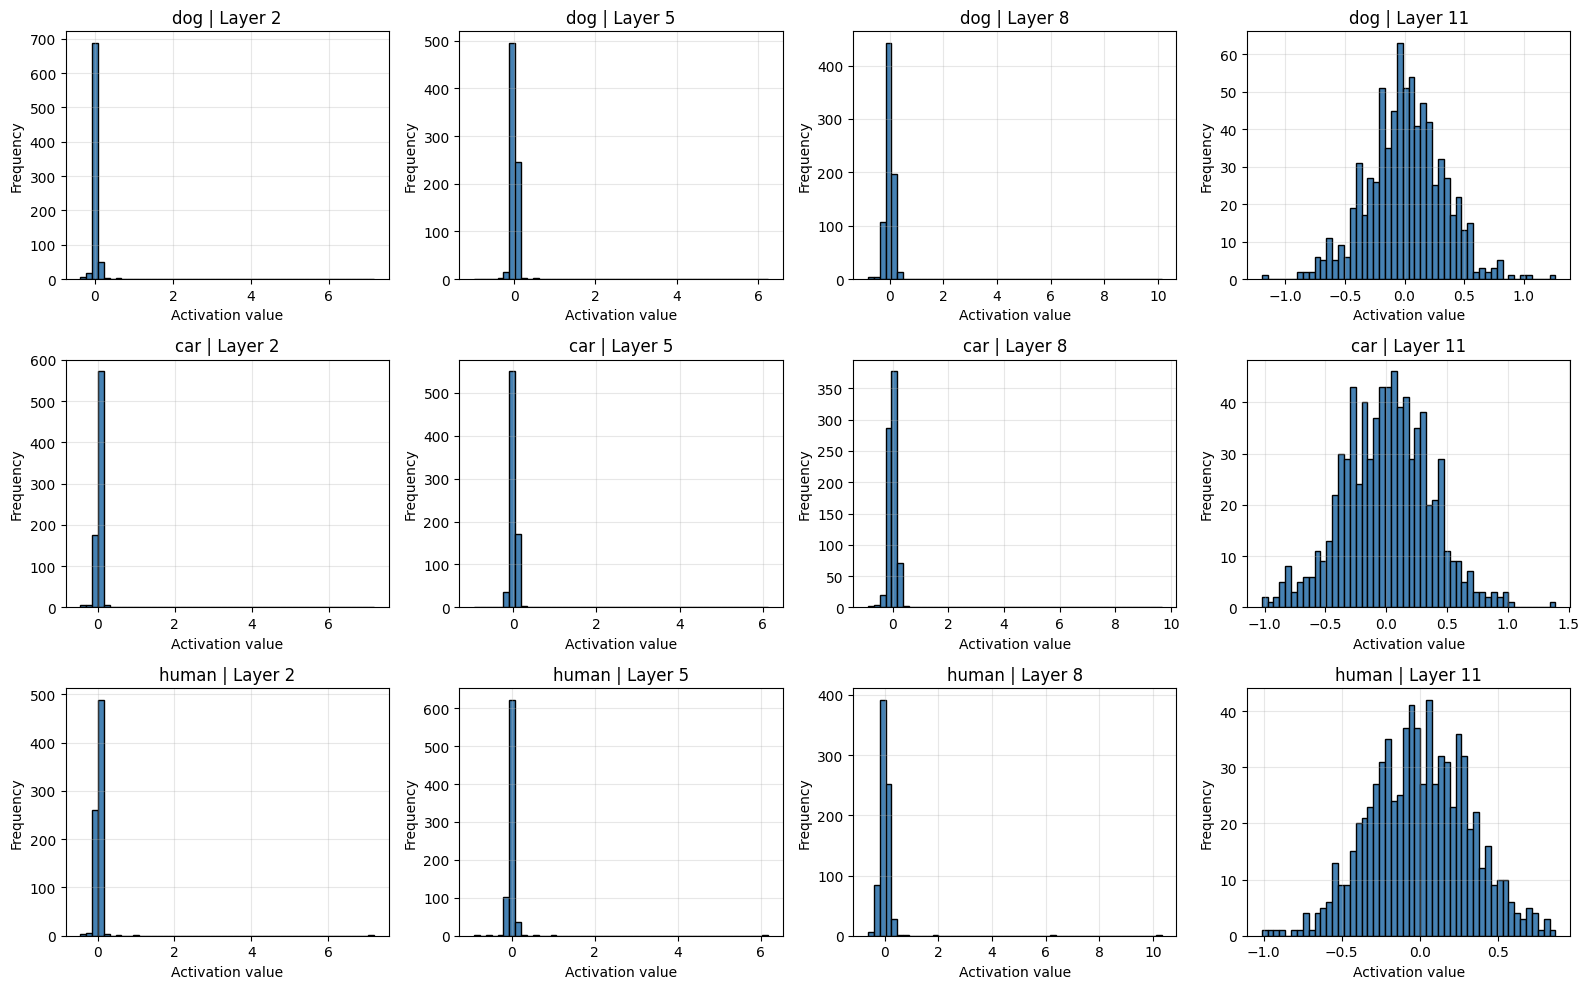

In [ ]:
# Визуализация активаций конкретных изображений на разных слоях
# Выберем 3 изображения для детального анализа: индексы 0 (собака), 1 (машина), 3 (человек)
selected_indices = [0, 1, 3]
selected_labels = ["dog", "car", "human"]

fig, axes = plt.subplots(len(selected_indices), 4, figsize=(16, 10))

for row_idx, img_idx in enumerate(selected_indices):
    for col_idx, layer_idx in enumerate([2, 5, 8, 11]):  # слои для сравнения
        activations = layer_activations[layer_idx][img_idx].squeeze().numpy()

        axes[row_idx, col_idx].hist(activations, bins=50, color='steelblue', edgecolor='black')
        axes[row_idx, col_idx].set_title(f"{selected_labels[row_idx]} | Layer {layer_idx}")
        axes[row_idx, col_idx].set_xlabel("Activation value")
        axes[row_idx, col_idx].set_ylabel("Frequency")
        axes[row_idx, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Слои:
- 2, 5, 8:
    - Скошено влево, пик около 0, высокая частота (350-700)
    - Активации концентрируются около нуля с длинным правым хвостом -> потенциальная разреженность при правильном пороге. Но семантическая информация ещё слабо выражена
- 11:
    - Визуально близко к нормальному, низкая частота (40-60)
    - Активации более равномерно распределены -> меньше разреженности

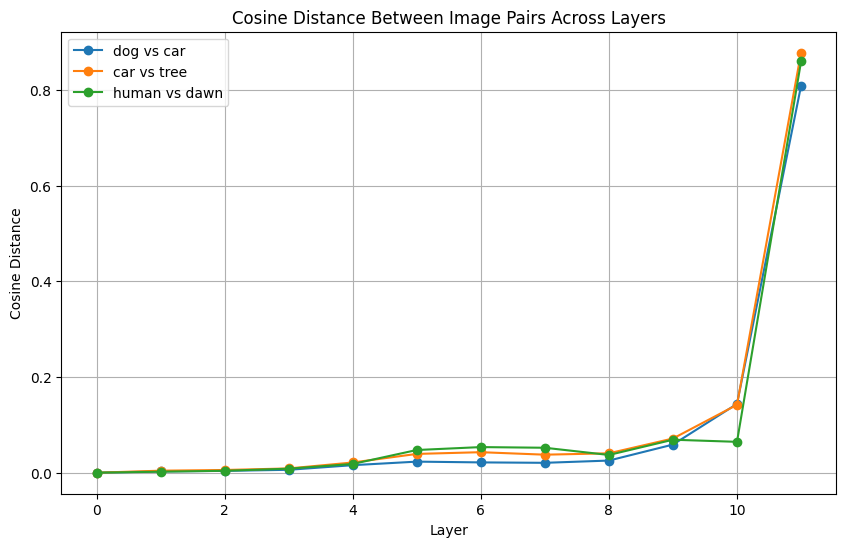

In [17]:
# Анализ семантической дифференциации между изображениями
pairwise_distances = {layer: [] for layer in range(12)}
image_pairs = [("dog", "car"), ("car", "tree"), ("human", "dawn")]

for layer_idx in range(12):
    activations = torch.cat(layer_activations[layer_idx], dim=0).numpy()  # [6, 768]
    for (label1, label2), (idx1, idx2) in zip(image_pairs, [(0,1), (1,2), (3,5)]):
        dist = cosine(activations[idx1], activations[idx2])
        pairwise_distances[layer_idx].append(dist)

# Визуализация динамики расстояний
fig, ax = plt.subplots(figsize=(10, 6))
for pair_idx, pair_name in enumerate(image_pairs):
    distances = [pairwise_distances[layer][pair_idx] for layer in range(12)]
    ax.plot(range(12), distances, marker='o', label=f"{pair_name[0]} vs {pair_name[1]}")

ax.set_title("Cosine Distance Between Image Pairs Across Layers")
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Distance")
ax.legend()
ax.grid(True)
plt.show()

- Слои 0-10:
    - изображения "слипаются" в латентном пространстве (малые расстояния), т.е. модель ещё не выделила семантические различия
- Слой 11:
    - резкая дифференциация (косинусное расстояние растет в несколько раз)

Кандидаты для использования в SAE:
1. Слой 8
    - Умеренная активность, начинает формироваться семантика
    - Низкая дисперсия (плохая дифференциация, фичи ещё не выразительны)
2. Слой 10
    - Максимальная дисперсия и норма: богатые представления
    - Косинусные расстояния выше других слоев, но не максимальны
3. Слой 11
    - Максимальная семантическая дифференциация
    - Снижение амплитуды активаций после пика
    - Соответствует методологии статьи "Towards Multimodal Interpretability: Learning Sparse Features in CLIP" (слой 22/24 для ViT-Large пропорционален слою 11/12 для ViT-B/32)

Т.к. нас в первую интересует семантическая интерпретация, используем слой 11 в дальнейшей работе